In [35]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
from util import datasets, methods, models, plot
import numpy as np
from os import path

In [37]:
# General parameters
batch_size = 1
data_root = "../data"
use_logits = True
normalize_attrs = False
aggregation_fn = "avg"

In [38]:
cifar = datasets.Cifar(batch_size=1, data_location=path.join(data_root, "CIFAR10"))
mnist = datasets.MNIST(batch_size=1, data_location=path.join(data_root, "MNIST"))

In [39]:
model = models.MNISTCNN(params_loc=path.join(data_root, "models/MNIST_cnn.pth"), output_logits=use_logits)
model.eval()
pass

In [15]:
model = models.CifarResnet(version="resnet20", params_loc=path.join(data_root, "models/CIFAR10_resnet20.pth"), num_classes=10, output_logits=use_logits)
model.eval()
pass

In [40]:
attribution_methods = {
    #"GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), normalize=normalize_attrs),
    "Gradient": methods.Gradient(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "InputXGradient": methods.InputXGradient(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "IntegratedGradients": methods.IntegratedGradients(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "GuidedBackprop": methods.GuidedBackprop(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "Deconvolution": methods.Deconvolution(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "Random": methods.Random(normalize=normalize_attrs, aggregation_fn=aggregation_fn)
}

In [44]:
img, label = next(iter(mnist.get_dataloader(train=True)))


<function AttributionMethod.__init__.<locals>.<lambda> at 0x7fb34eda4bf8>


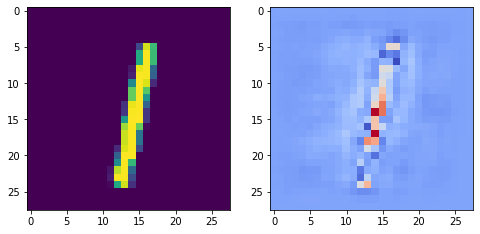

In [45]:
attrs = attribution_methods["InputXGradient"](img, label)
plot.plot_image_with_attributions(img[0].detach().numpy(), attrs[0].detach().numpy())